In [1]:
import torch
import torch.nn as nn
import pandas as pd
import math
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
df = pd.read_csv("/kaggle/input/dataset/xy_data.csv")
x_data = torch.tensor(df["x"].values, dtype=torch.float32)
y_data = torch.tensor(df["y"].values, dtype=torch.float32)

torch.manual_seed(42)

In [3]:
theta = torch.tensor([25.0], requires_grad=True) 
M = torch.tensor([0.02], requires_grad=True)
X = torch.tensor([40.0], requires_grad=True)

params = [theta, M, X]
optimizer = torch.optim.Adam(params, lr=0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.7)
loss_fn_L2 = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

In [4]:
def forward(theta, M, X):
    th = torch.deg2rad(theta)
    c, s = torch.cos(th), torch.sin(th)
    t = (x_data - X) * c + (y_data - 42) * s
    y_obs = -(x_data - X) * s + (y_data - 42) * c
    y_model = torch.exp(M * torch.abs(t)) * torch.sin(0.3 * t)
    return t, y_obs, y_model

In [ ]:
for epoch in range(4000):
    optimizer.zero_grad(set_to_none=True)
    t, y_obs, y_model = forward(theta, M, X)
    
    
    if epoch < 2000:
        loss = loss_fn_L2(y_obs, y_model)
    else:
        loss = loss_fn_L1(y_obs, y_model)
    
    
    loss += 0.05 * torch.mean(torch.relu(6 - t) + torch.relu(t - 60))
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d}: Loss={loss.item():.6e}, θ={theta.item():.4f}, M={M.item():.5f}, X={X.item():.4f}")


Epoch    0: Loss=3.170546e+01, θ=24.9800, M=0.00000, X=40.0200
Epoch  500: Loss=7.963221e+00, θ=23.0454, M=-0.18047, X=44.5382
Epoch 1000: Loss=6.715466e+00, θ=24.7696, M=-0.13325, X=47.8602
Epoch 1500: Loss=1.855677e+00, θ=27.6637, M=0.02487, X=53.0568
Epoch 2000: Loss=5.114260e-03, θ=29.9881, M=0.03026, X=54.9919
Epoch 2500: Loss=1.391040e-01, θ=30.0012, M=0.02653, X=55.0009
Epoch 3000: Loss=1.295772e-01, θ=29.9981, M=0.03195, X=55.0004
Epoch 3500: Loss=4.034488e-02, θ=29.9998, M=0.03093, X=54.9995


In [6]:

print(f"Theta (degrees): {theta.item():.6f}")
print(f"M: {M.item():.6f}")
print(f"X: {X.item():.6f}")

Theta (degrees): 29.999794
M: 0.029241
X: 55.000210


In [7]:
with torch.no_grad():
    t_vals = torch.linspace(6, 60, 800)
    th = torch.deg2rad(theta)
    c, s = torch.cos(th), torch.sin(th)
    x_fit = t_vals * c - torch.exp(M * torch.abs(t_vals)) * torch.sin(0.3 * t_vals) * s + X
    y_fit = 42 + t_vals * s + torch.exp(M * torch.abs(t_vals)) * torch.sin(0.3 * t_vals) * c

x_fit = x_fit.detach().numpy()
y_fit = y_fit.detach().numpy()

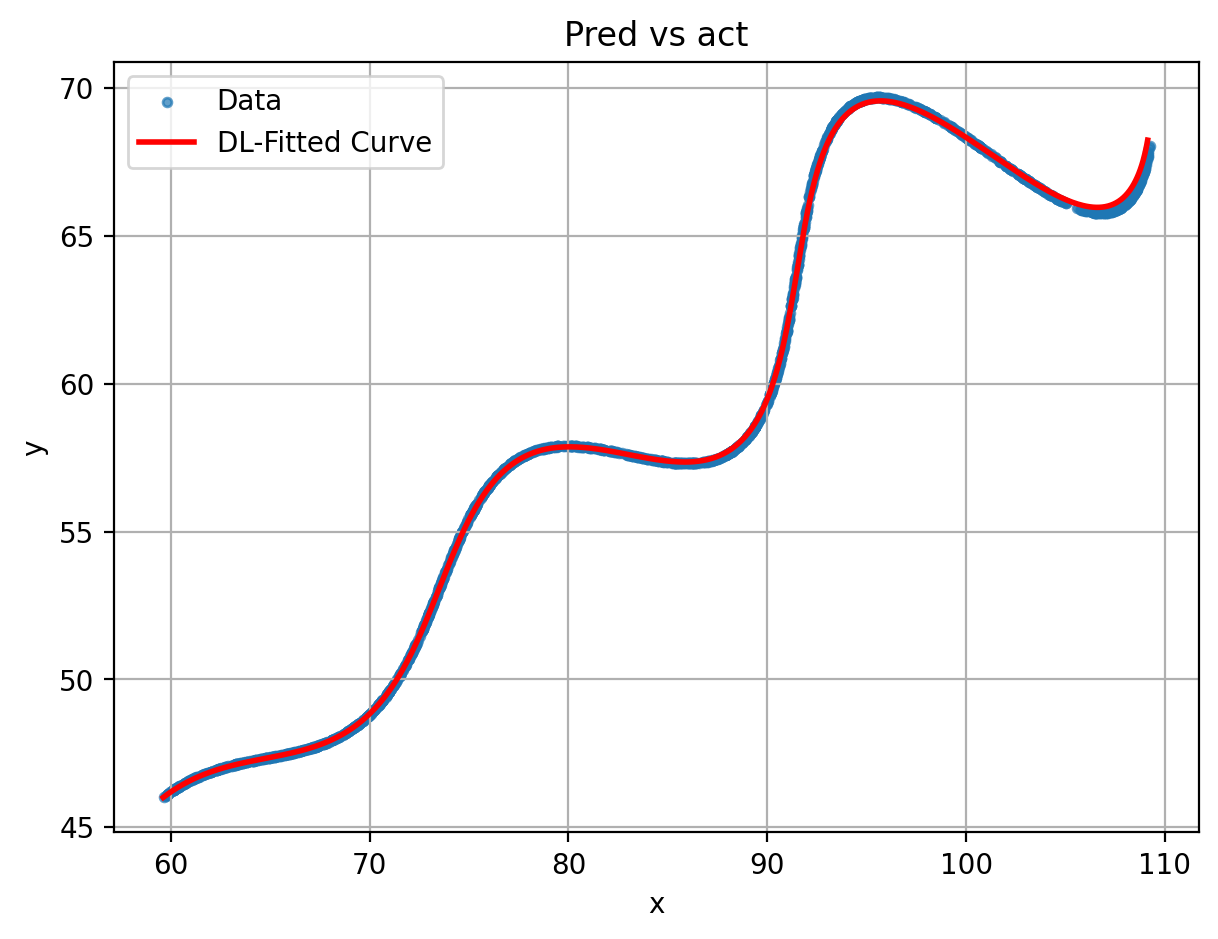

In [8]:
plt.figure(figsize=(7,5))
plt.scatter(df["x"], df["y"], s=10, label="Data", alpha=0.7)
plt.plot(x_fit, y_fit, 'r-', lw=2, label="DL-Fitted Curve")
plt.legend()
plt.title("Pred vs act")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("curve_fit_result.png", dpi=200, bbox_inches="tight")

display(Image(filename="curve_fit_result.png"))